# importing libraries

In [31]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models,transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [32]:
dataset_path = r"D:\ml_projects\haar_caascade\dataset_utk\UTKFace\crop_part1"
image_files = os.listdir(dataset_path)

# preprocessing image

In [33]:
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = image / 255.0  
    
    return image

In [34]:
def extract_age(filename):
    return int(filename.split('_')[0])

In [35]:
images = []
ages = []  
for file in tqdm(image_files):
    image_path = os.path.join(dataset_path, file)
    image = preprocess_image(image_path)
    images.append(image)
    ages.append(extract_age(file))  

100%|██████████| 9780/9780 [00:10<00:00, 906.52it/s] 


In [36]:
images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)

In [37]:
images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)  # Ensure ages are also a NumPy array

In [38]:
print(ages[:5])

[100. 100. 101.  10.  10.]


In [39]:
print(f'Total images: {images.shape}')

Total images: (9780, 128, 128, 3)


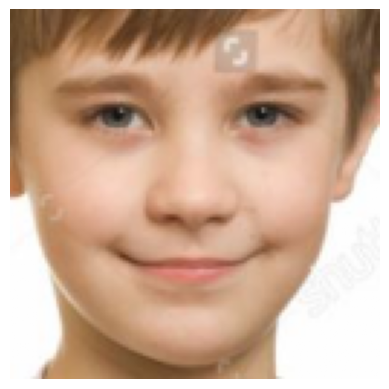

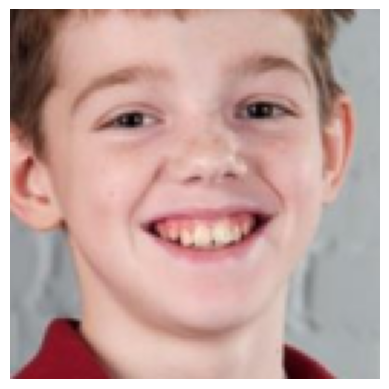

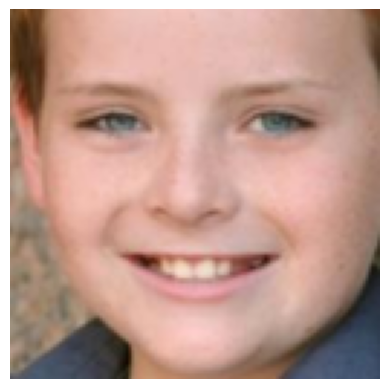

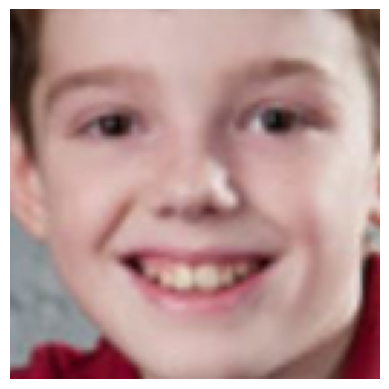

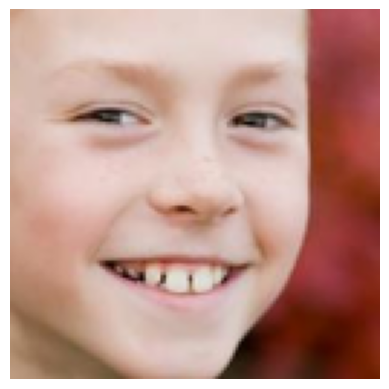

In [40]:
import matplotlib.pyplot as plt
for i in range(50,55): 
    plt.figure()
    plt.imshow(images[i])  
    plt.axis('off')  
    plt.show()

# data spliting

In [41]:
X_train, X_val, y_train, y_val = train_test_split(images, ages, test_size=0.2, random_state=82)

print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')


Training set size: 7824
Validation set size: 1956


In [42]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

In [43]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# fine tune

In [44]:
model = models.resnet18(pretrained=True)

for name, param in model.named_parameters():
    if 'layer4' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  


c:\Users\ABHIRAM\anaconda3\envs\amazonml\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ABHIRAM\anaconda3\envs\amazonml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
criterion = nn.MSELoss()  # Suitable for age regression
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adjusted learning rate

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [47]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model = model.to(device)  

    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0.0

    
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float()

            images = images.permute(0, 3, 1, 2)

            optimizer.zero_grad() 
            outputs = model(images)  
            loss = criterion(outputs.squeeze(), labels)  
            loss.backward()  
            optimizer.step()  

            train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()  
        val_loss = 0.0
        with torch.no_grad():  
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()

                images = images.permute(0, 3, 1, 2)
                outputs = model(images) 
                loss = criterion(outputs.squeeze(), labels)  
                val_loss += loss.item() * images.size(0)


        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

In [48]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch 1/10, Training Loss: 580.8863, Validation Loss: 184.5743
Epoch 2/10, Training Loss: 130.2752, Validation Loss: 105.4169
Epoch 3/10, Training Loss: 78.7926, Validation Loss: 86.8258


KeyboardInterrupt: 

Training Stopped Early To Avoid Overfitting

In [49]:
torch.save(model.state_dict(), "age_prediction_model.pth")

In [ ]:
images = []
ages = []  
for file in tqdm(image_files):
    image_path = os.path.join(dataset_path, file)
    if os.path.isfile(image_path):  # Check if the file path is valid
        image = preprocess_image(image_path)
        images.append(image)
        ages.append(extract_age(file))


images = np.array(images, dtype=np.float32)
ages = np.array(ages, dtype=np.float32)


print(f'Total images processed: {len(images)}')
print(f'Total ages collected: {len(ages)}')

print(f'Shape of images: {images.shape}')
print(f'Shape of ages: {ages.shape}')


Mean Squared Error on the entire dataset: 35.3780


so rms loss is sqrt(35.3780)

In [99]:
np.sqrt(35.37800)

5.947940820149441

so error is +/- 5.9479 years

5.947940820149441

Testing on a Known Outside Image of a Subject of age 19 years

Predicted Age: 18.90


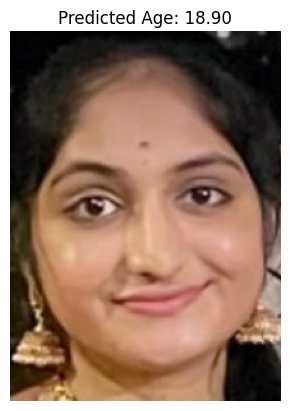

In [105]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def preprocess_single_image(image_path, target_size=(128, 128)):

    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    image = image.unsqueeze(0)  
    return image

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = r"C:\Users\ABHIRAM\Downloads\test_image_22.jpg"

input_image = preprocess_single_image(image_path).to(device) 

with torch.no_grad(): 
    output = model(input_image).squeeze()  
    predicted_age = output.item() 
print(f"Predicted Age: {predicted_age:.2f}")

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  

plt.imshow(original_image)
plt.title(f"Predicted Age: {predicted_age:.2f}")
plt.axis('off')  
plt.show()


Testing on Trained Dataset

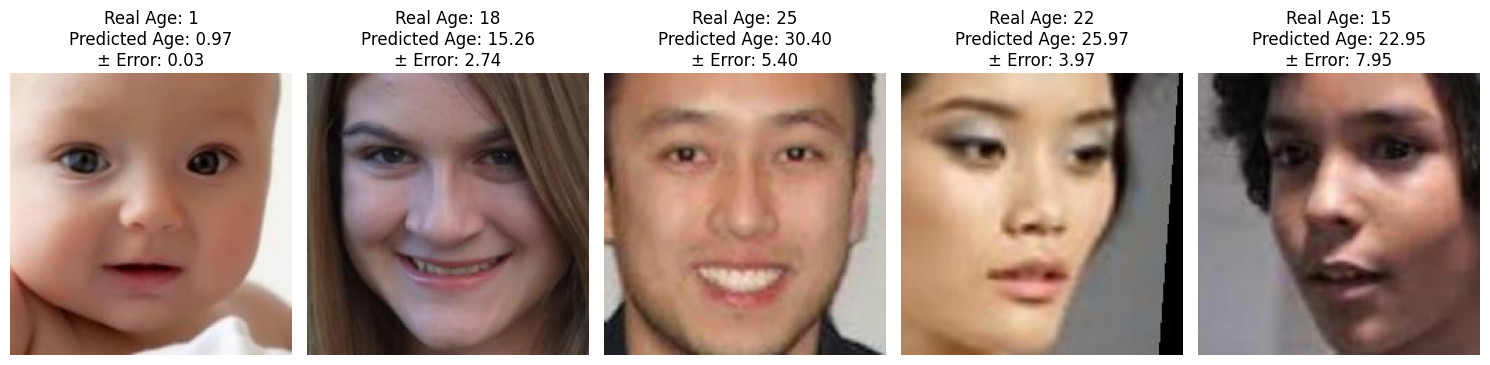

In [110]:
import random
import matplotlib.pyplot as plt
import cv2
import torch

def preprocess_single_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  
    image = image.unsqueeze(0)  
    return image
def extract_age(filename):
    return int(filename.split('_')[0])
def plot_and_predict_random_images(image_files, model, num_images=5):
    selected_files = random.sample(image_files, num_images)
    plt.figure(figsize=(15, 10))
    
    for i, file in enumerate(selected_files):
        image_path = os.path.join(dataset_path, file)
        input_image = preprocess_single_image(image_path).to(device)
        real_age = extract_age(file)
        with torch.no_grad():
            output = model(input_image).squeeze()  
            predicted_age = output.item()  
        error = abs(predicted_age - real_age)
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(original_image)
        plt.title(f"Real Age: {real_age}\nPredicted Age: {predicted_age:.2f}\n± Error: {error:.2f}")
        plt.axis('off')  
    
    plt.tight_layout()
    plt.show()

plot_and_predict_random_images(image_files, model, num_images=5)  # Change num_images as needed
